# Missing Data

Missing data within well logs can arise due to a multitude of reasons, including: 
- missing by choice
- data vintage
- missing in deliverables
- tool or sensor failures
- bad data intervals may have been manually removed during a previous interpretation 

The consequences and impact of the missing data can vary in scale and is dependent on the extent of the missing data. When large amounts of key data are missing, there can be significant consequences to operators including impacts on future exploration and development operations, reserves estimation and financial decisions. Additionally, it is often the case that surface to total depth logs are required for complete Reservoir Seismic Characterisation, therefore if only part of the data is available then only a partial characterisation can be performed.

A full discussion on missing values and their impacts on machine learning models will be presented at this years conference and is detailed within the following paper: *McDonald, A., 2022. Impact of missing data on petrophysical regression-based machine learning model performance*

Within Python there are a number of tools we can use to identify missing data, some of these methods include:

- Pandas Dataframe summaries
- MissingNo Library
- Data Visualisations

How to handle missing data is controversial, some argue that data should be filled in using techniques such as: mean imputation and regression imputation, whereas others argue that it is best to remove that data to prevent adding further uncertainty to the final results.

In this notebook, we are going to use two main techniques for dealing with missing data: 
- **Variable Discarding** - This involves removing one or more features from the dataset if the missing values are extant within those features. This has consequences when building a machine learning model, as models require a full suite of features in all wells in order to train and make predictions.
- **Listwise Deletion** - This is a common and convenient method for dealing with incomplete data and has become the default method. It involves removing rows within the dataset if one of the values in that row is missing. With well logs, this is equivalent to removal of a single depth level. Even though this method is fast and convenient, it can reduce the data size, which can impact the predictive power of the machine learning model.

# Importing Libraries & Data
The first step is to import the libraries that we will require for working with the data. 
For this notebook, we will be using:
- pandas for loading and storing the data
- matplotlib and seaborn for visualising the data
- numpy for a number of calculation methods
- missingno to visualise where missing data exists

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np

Next, we will load the data in using the pandas `read_csv` function and assign it to the variable `df`. The data will now be stored within a structured object known as a dataframe.

In [2]:
df = pd.read_csv('data/spwla_volve_data.csv')

As seen in the previous notebook, we can call upon a few methods to check the data quality. 

The `.head()` method allows us to view the first 5 rows of the dataframe.

In [3]:
df.head()

,wellName,MD,BS,CALI,DT,DTS,GR,NPHI,RACEHM,RACELM,RHOB,RPCEHM,RPCELM,PHIF,SW,VSH
0,15/9-F-1 A,3431.0,8.5,8.6718,86.9092,181.2241,53.9384,0.3222,0.5084,0.8457,2.7514,0.6461,0.6467,0.02,1.0,0.6807
1,15/9-F-1 A,3431.1,8.5,8.6250,86.4334,181.1311,57.2889,0.3239,0.4695,0.8145,2.7978,0.7543,0.6570,0.02,1.0,0.7316
2,15/9-F-1 A,3431.2,8.5,8.6250,85.9183,180.9487,59.0455,0.3277,0.5012,0.8048,2.8352,0.8718,0.6858,0.02,1.0,0.7583
3,15/9-F-1 A,3431.3,8.5,8.6250,85.3834,180.7211,58.2550,0.3357,0.6048,0.7984,2.8557,0.9451,0.7913,0.02,1.0,0.7462
4,15/9-F-1 A,3431.4,8.5,8.6250,84.8484,180.4930,59.4569,0.3456,0.7115,0.7782,2.8632,1.0384,0.8730,0.02,1.0,0.7646


The describe method provides us some summary statistics. To identify if we have missing data using this method, we need to look at the count row. If we assume that MD (measured depth) is the most complete column, we have 27,845 data points. Now, if we look at DT and DTS, we can see we only have 5,493 and 5,420 data points respectively. A number of other columns also have lower numbers, namely: RPCELM, PHIF, SW, VSH.

In [4]:
df.describe()

,MD,BS,CALI,DT,DTS,GR,NPHI,RACEHM,RACELM,RHOB,RPCEHM,RPCELM,PHIF,SW,VSH
count,27845.000000,27845.0,27845.000000,5493.000000,5420.000000,27845.000000,27845.000000,27845.000000,27845.000000,27845.000000,27845.000000,27600.000000,27736.000000,27736.000000,2.784400e+04
mean,3816.224960,8.5,8.625875,78.000104,131.027912,38.529140,0.188131,352.689922,97.558930,2.379268,1561.079977,30.041154,0.157434,0.531684,2.724204e-01
std,398.843662,0.0,0.079941,7.730495,13.230939,21.814711,0.053390,1367.355219,395.725094,0.162293,9570.308431,210.915588,0.075957,0.353637,1.872371e-01
min,3223.000000,8.5,8.304900,54.280000,83.574000,6.869100,0.024000,0.197400,0.234900,1.627000,0.139000,0.136600,0.001000,0.043000,1.820000e-15
25%,3503.000000,8.5,8.556900,72.562500,123.403425,21.128200,0.157000,1.856400,1.781000,2.240000,2.148300,1.884000,0.091000,0.201000,1.258000e-01
50%,3713.300000,8.5,8.625000,77.228000,131.864350,35.071000,0.183900,4.035800,3.681200,2.356000,5.136800,4.195400,0.178000,0.433000,2.400000e-01
75%,4057.000000,8.5,8.672000,84.342900,138.017500,49.178300,0.215200,14.929000,8.891000,2.502500,24.687400,14.782650,0.225000,1.000000,3.540000e-01
max,4744.000000,8.5,9.175000,96.277600,186.090800,127.055700,0.541000,6381.099100,2189.603000,3.090000,62290.770000,5571.435100,0.292000,1.000000,1.000000e+00


To gain a clearer insight, we can call upon the `info()` method to see how many non-null values exist for each column. Right away we can see the ones highlighted previously have lower numbers of non-null values.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27845 entries, 0 to 27844
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   wellName  27845 non-null  object 
 1   MD        27845 non-null  float64
 2   BS        27845 non-null  float64
 3   CALI      27845 non-null  float64
 4   DT        5493 non-null   float64
 5   DTS       5420 non-null   float64
 6   GR        27845 non-null  float64
 7   NPHI      27845 non-null  float64
 8   RACEHM    27845 non-null  float64
 9   RACELM    27845 non-null  float64
 10  RHOB      27845 non-null  float64
 11  RPCEHM    27845 non-null  float64
 12  RPCELM    27600 non-null  float64
 13  PHIF      27736 non-null  float64
 14  SW        27736 non-null  float64
 15  VSH       27844 non-null  float64
dtypes: float64(15), object(1)
memory usage: 3.4+ MB


## Using missingno to Visualise Data Sparsity

The missingno library is designed to take a dataframe and allow you to visualise where gaps may exist. 

We can simply call upon the `.matrix()` method and pass in the dataframe object. When we do, we generate a graphical view of the dataframe.

In the plot below, we can see that there are significant gaps within the DT and DTS columns, with minor gaps in the RPCELM, PHIF, and SW columns. 

The sparkline to the right hand side of the plot provides an indication of data completeness. If the line is at the maximum value (to the right) it shows that data row as being complete. 

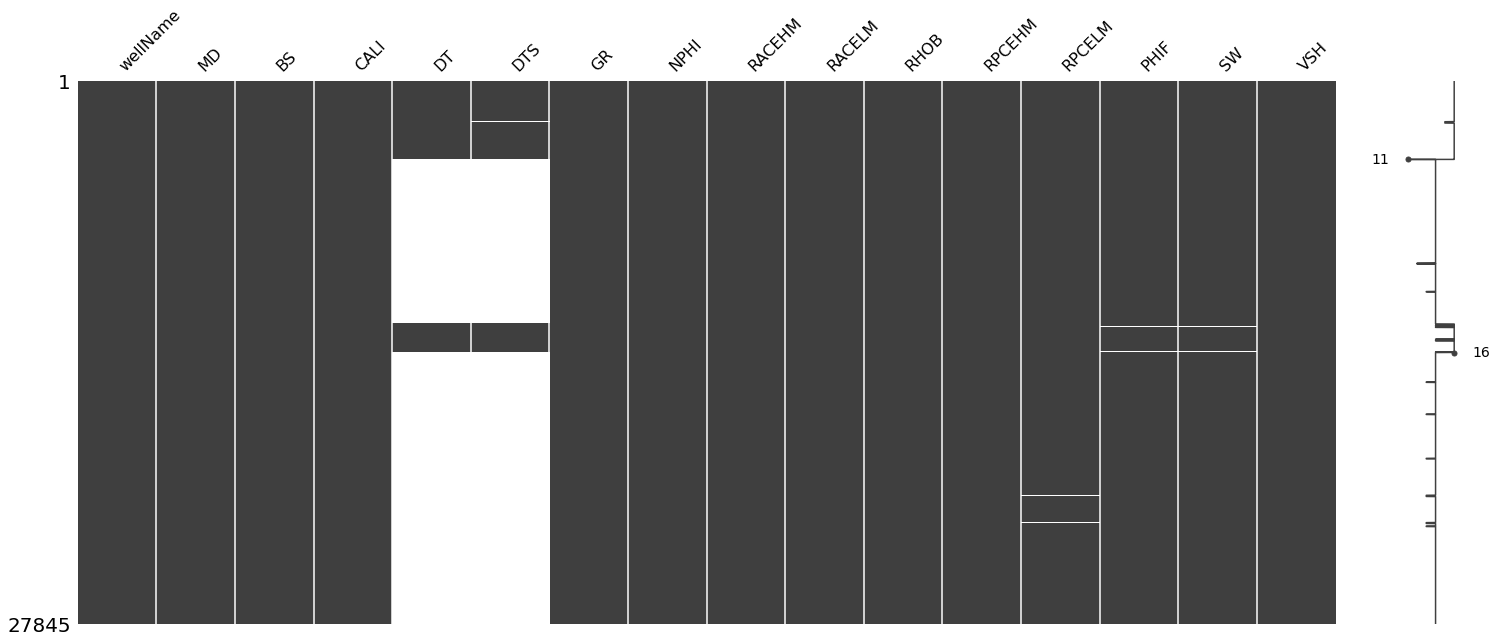

In [6]:
msno.matrix(df)
plt.show()

Another plot we can call upon is the bar plot, which provides a graphical summary of the number of points in each columns.

<AxesSubplot:>

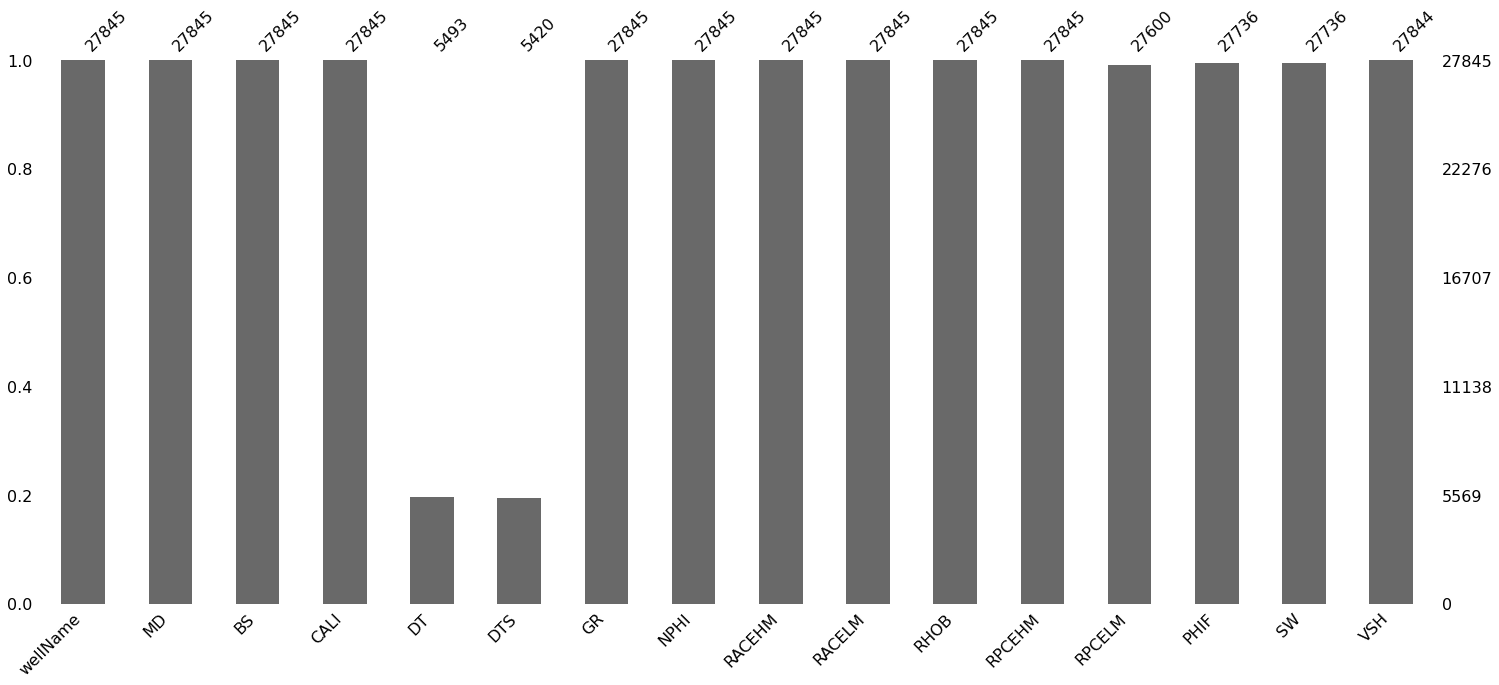

In [7]:
msno.bar(df)

## Using matplotlib to Visualise Missing Data in Well

We can generate our own plots to show how the data sparsity varies across each of the wells. In order to do this, we need to manipulate the dataframe.

First we create a copy of the dataframe to work on separately, and then replace each column with a value of 1 if the data is non-null.

To make our plot work, we need to increment each column's value by 1. This allows us to plot each column as an offset to the previous one.

In [9]:
data_nan = df.copy()
for num, col in enumerate(data_nan.columns[2:]):
    data_nan[col] = data_nan[col].notnull() * (num + 1)
    data_nan[col].replace(0, num, inplace=True)

When we view the header of the dataframe we now have a series of columns with increasing values from 1 to 14.

In [10]:
data_nan.head()

,wellName,MD,BS,CALI,DT,DTS,GR,NPHI,RACEHM,RACELM,RHOB,RPCEHM,RPCELM,PHIF,SW,VSH
0,15/9-F-1 A,3431.0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,15/9-F-1 A,3431.1,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2,15/9-F-1 A,3431.2,1,2,3,4,5,6,7,8,9,10,11,12,13,14
3,15/9-F-1 A,3431.3,1,2,3,4,5,6,7,8,9,10,11,12,13,14
4,15/9-F-1 A,3431.4,1,2,3,4,5,6,7,8,9,10,11,12,13,14


Next, we can group the dataframe by the wellName column.

In [11]:
grouped = data_nan.groupby('wellName')

We can then create multiple subplots for each well using the new dataframe. Rather than creating subplots within subplots, we can shade from the previous column's max value to the current column's max value if the data is present. If data is absent, it will be displayed as a gap.

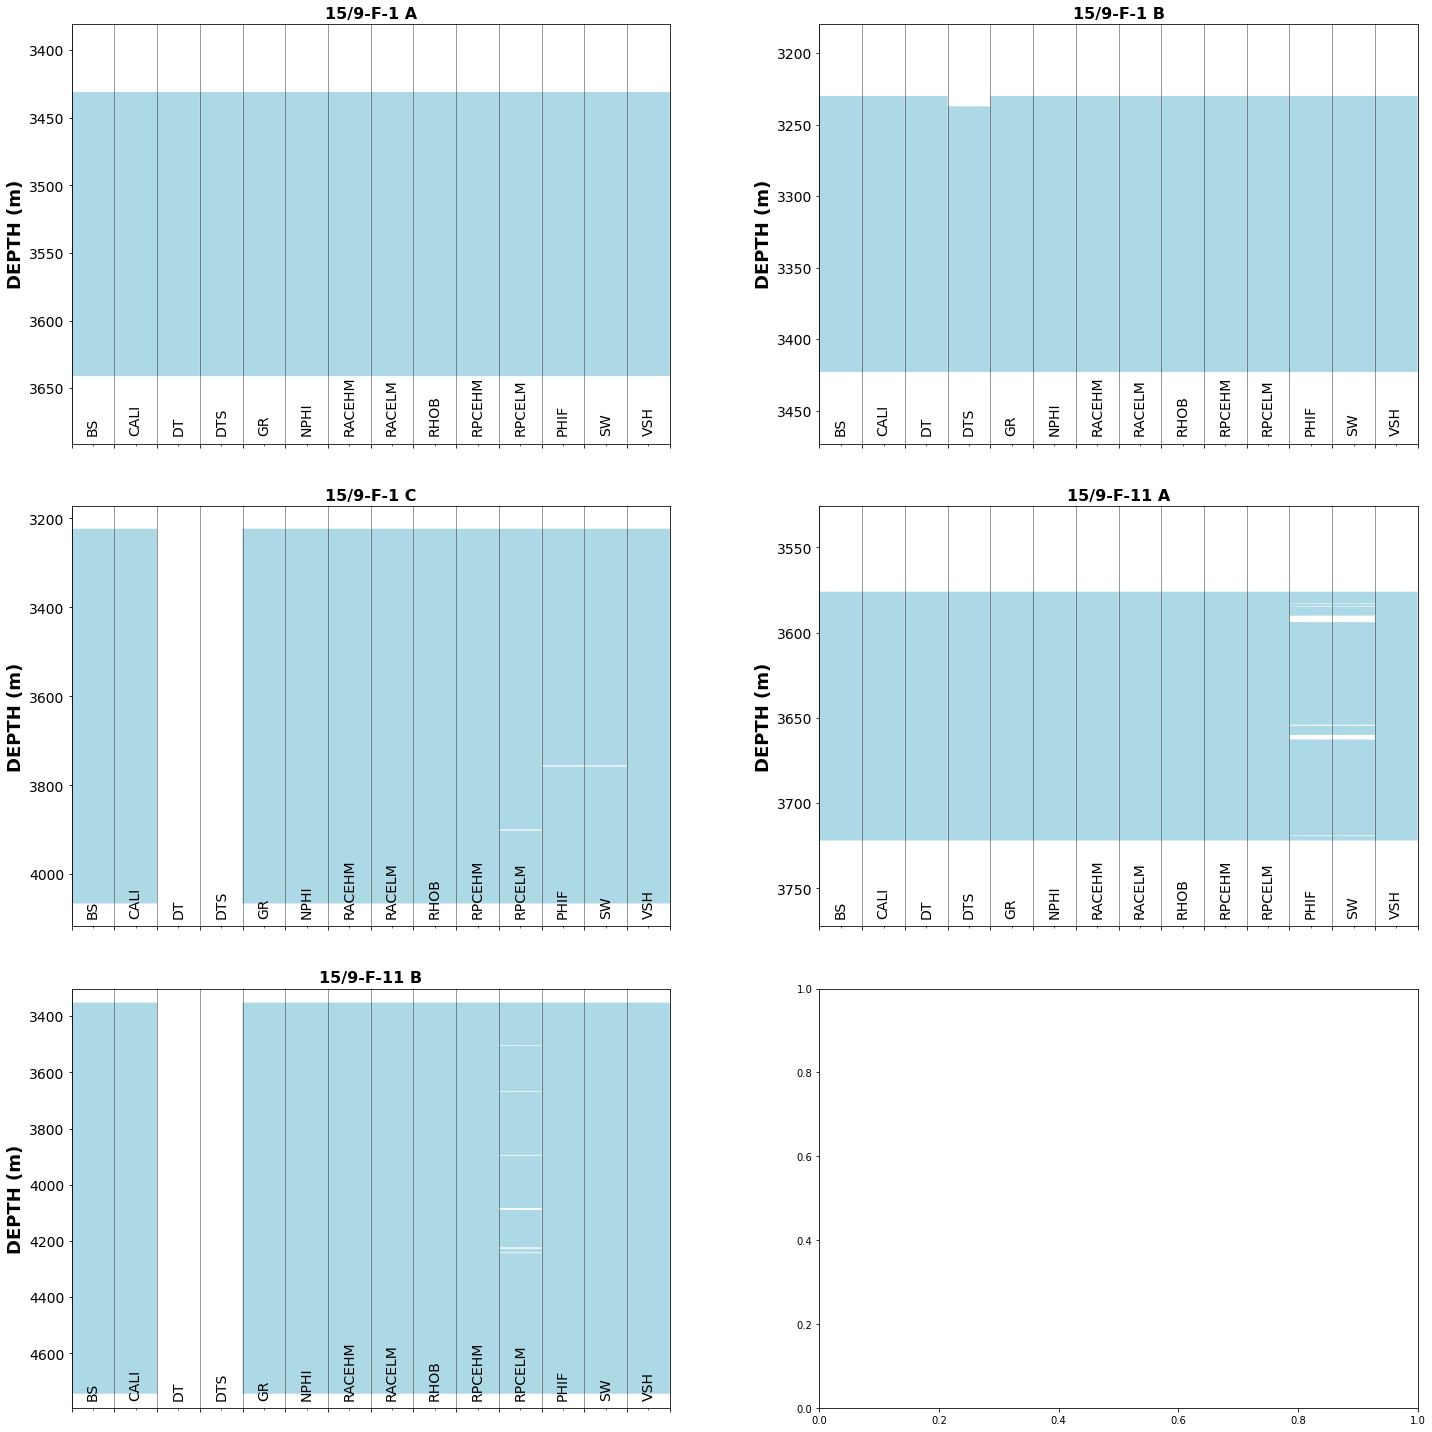

In [12]:
#Setup the labels we want to display on the x-axis
labels = ['BS', 'CALI', 'DT', 'DTS', 'GR', 'NPHI', 'RACEHM', 'RACELM', 'RHOB', 'RPCEHM', 'RPCELM', 'PHIF', 'SW', 'VSH']
#Setup the figure and the subplots
fig, axs = plt.subplots(3, 2, figsize=(20,20))
#Loop through each well and column in the grouped dataframe
for (name, well), ax in zip(grouped, axs.flat):
    ax.set_xlim(0,9)
    
    #Setup the depth range
    ax.set_ylim(well.MD.max() + 50, well.MD.min() - 50)
    ax.set_ylim(well.MD.max() + 50, well.MD.min() - 50)
    
    # Create multiple fill betweens for each curve# This is between
    # the number representing null values and the number representing
    # actual values
    ticks = []
    ticks_labels = []
    for i, curve in enumerate(labels):
        ax.fill_betweenx(well.MD, i, well[curve], facecolor='lightblue')
        ticks.append(i)
        ticks_labels.append(i+0.5)
    
    # add extra value on to ticks
    ticks.append(len(ticks))
    
    #Setup the grid, axis labels and ticks
    ax.grid(axis='x', alpha=0.5, color='black')
    ax.set_ylabel('DEPTH (m)', fontsize=18, fontweight='bold')
    
    #Position vertical lines at the boundaries between the bars
    ax.set_xticks(ticks, minor=False)
    
    #Position the curve names in the centre of each column
    ax.set_xticks(ticks_labels, minor=True)
    
    #Setup the x-axis tick labels
    ax.set_xticklabels(labels,  rotation='vertical', minor=True, verticalalignment='bottom', fontsize=14)
    ax.set_xticklabels('', minor=False)
    ax.tick_params(axis='x', which='minor', pad=-10)
    ax.tick_params(axis='y', labelsize=14 )
    
    #Assign the well name as the title to each subplot
    ax.set_title(name, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(hspace=0.15, wspace=0.25)
# plt.savefig('missingdata.png', dpi=200)
plt.show()

From the plot, we can not only see the data range of each well, but we can also see that 2 of the 5 wells have missing DT and DTS curves, 2 of the wells have missing data within RPCELM, and 2 of the wells have missing values in the PHIF and SW curves.

## Dealing With Missing Data
### Discarding Variables

As DT and DTS are missing in two of the wells, we have the option to remove these wells from the dataset, or we can remove these two columns for all of the wells.

The following is an example of how we remove the two curves from the dataframe. For this we can pass in a list of the columns names to the `drop()` function, the axis, which we want to drop data along, in this case the columns (axis=1), and the `inplace=True` argument allows us to physically remove these values from the dataframe.

In [13]:
df.drop(df[['DT', 'DTS']], axis=1, inplace=True)

If we view the header of the dataframe, we will see that we have removed the required columns.

In [14]:
df.head()

,wellName,MD,BS,CALI,GR,NPHI,RACEHM,RACELM,RHOB,RPCEHM,RPCELM,PHIF,SW,VSH
0,15/9-F-1 A,3431.0,8.5,8.6718,53.9384,0.3222,0.5084,0.8457,2.7514,0.6461,0.6467,0.02,1.0,0.6807
1,15/9-F-1 A,3431.1,8.5,8.6250,57.2889,0.3239,0.4695,0.8145,2.7978,0.7543,0.6570,0.02,1.0,0.7316
2,15/9-F-1 A,3431.2,8.5,8.6250,59.0455,0.3277,0.5012,0.8048,2.8352,0.8718,0.6858,0.02,1.0,0.7583
3,15/9-F-1 A,3431.3,8.5,8.6250,58.2550,0.3357,0.6048,0.7984,2.8557,0.9451,0.7913,0.02,1.0,0.7462
4,15/9-F-1 A,3431.4,8.5,8.6250,59.4569,0.3456,0.7115,0.7782,2.8632,1.0384,0.8730,0.02,1.0,0.7646


However, if we call upon the info method, we can see we still have null values within the dataframe.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27845 entries, 0 to 27844
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   wellName  27845 non-null  object 
 1   MD        27845 non-null  float64
 2   BS        27845 non-null  float64
 3   CALI      27845 non-null  float64
 4   GR        27845 non-null  float64
 5   NPHI      27845 non-null  float64
 6   RACEHM    27845 non-null  float64
 7   RACELM    27845 non-null  float64
 8   RHOB      27845 non-null  float64
 9   RPCEHM    27845 non-null  float64
 10  RPCELM    27600 non-null  float64
 11  PHIF      27736 non-null  float64
 12  SW        27736 non-null  float64
 13  VSH       27844 non-null  float64
dtypes: float64(13), object(1)
memory usage: 3.0+ MB


### Discarding NaNs

We can drop missing values by calling upon a special function called `dropna()`. This will remove any NaN (Not a Number) values from the dataframe. The `inplace=True` argument allows us to physically remove these values from the dataframe.

In [16]:
df.dropna(inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27491 entries, 0 to 27844
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   wellName  27491 non-null  object 
 1   MD        27491 non-null  float64
 2   BS        27491 non-null  float64
 3   CALI      27491 non-null  float64
 4   GR        27491 non-null  float64
 5   NPHI      27491 non-null  float64
 6   RACEHM    27491 non-null  float64
 7   RACELM    27491 non-null  float64
 8   RHOB      27491 non-null  float64
 9   RPCEHM    27491 non-null  float64
 10  RPCELM    27491 non-null  float64
 11  PHIF      27491 non-null  float64
 12  SW        27491 non-null  float64
 13  VSH       27491 non-null  float64
dtypes: float64(13), object(1)
memory usage: 3.1+ MB


# Summary

This short notebook has shown three separate ways to visualise missing data. T
1. Interrogating the dataframe
2. Using the missingno library 
3. Creating a custom visualisation with matplotlib.

At the end, we covered two ways in which missing data can be removed from the dataframe. The first by discarding variables, and the second by discarding missing values within the rows.
